**Clasificación mediante redes neuronales**

<p align="justify">En este apartado vamos a realizar la clasificación de nuestros datos usando técnicas de Deep Learning. Para ello usaremos tanto redes neuronales convolucionales como redes neuronales recurrentes.

In [ ]:
!pip install pyyaml

In [ ]:
import yaml

# Creamos una función que cree un dataset a partir de un fichero yaml
def yaml_to_dataset(file_path):
    with open(file_path, 'r', encoding="utf8") as file:
        data = yaml.safe_load(file)

    messages = [d['message'] for d in data]
    labels = [d['label'] for d in data]

    return {'data': messages, 'labels': labels}

In [ ]:
!pip install spacy
!python -m spacy download es_core_news_lg

^C


In [ ]:
import re
import string
import unicodedata
import spacy
from spacy.lang.es.stop_words import STOP_WORDS

# Creamos la función auxiliar para reemplazar las abreviaciones
def replace_abbreviations(text, abbreviations):

    for key, value in abbreviations.items():
        text = re.sub(r'\b{}\b'.format(key), value, text)
    return text


abbreviations = {
    'x' : 'por',
    'xq': 'porque',
    'pq': 'porque',
    'k': 'que',
    'tb': 'también',
    'tmb': 'también',
    'd': 'de',
    'cn': 'con',
    'm': 'me',
    'q': 'que',
    'qe': 'que',
    't': 'te',
}

nlp = spacy.load('es_core_news_lg')

# Creamos la función para preprocesar y tokenizar el dataset
def preprocess_tokenize_spanish(text):

  # Pasamos todo el texto a minúsculas
  text = text.lower()

  # Reemplazamos las abreviaciones
  text = replace_abbreviations(text, abbreviations)

  # Borramos las URL que puedan contener los mensajes
  text = re.sub(r'http\S+', '', text)

  # Cargamos una lista de signos de puntuación para eliminarlos al preprocesar
  punctuations = string.punctuation + '...' + '--' + '``' + '\'' + ''
  text = text.translate(str.maketrans('', '', punctuations))

  # Reemplazamos las letras acentuadas por sus equivalentes no acentuadas
  text = unicodedata.normalize('NFKD', text).encode('ASCII', 'ignore').decode('utf-8')

  # Tokenizamos y generalizamos
  doc = nlp(text)
  tokens = [token.lemma_ for token in doc if token not in STOP_WORDS]

  return tokens

In [ ]:
!pip install tensorflow
!pip install gensim

  Using cached numpy-1.24.3-cp310-cp310-win_amd64.whl (14.8 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.25.1
    Uninstalling numpy-1.25.1:
      Successfully uninstalled numpy-1.25.1


ERROR: Could not install packages due to an OSError: [WinError 5] Acceso denegado: 'C:\\Users\\34653\\anaconda3\\envs\\colab\\Lib\\site-packages\\~umpy\\.libs\\libopenblas64__v0.3.23-gcc_10_3_0.dll'
Consider using the `--user` option or check the permissions.



<p align="justify"> En primer lugar empezaremos usando para clasificar un modelo de red neuronal convolucional. Este tipo de redes destacan por sus usos en las tareas que involucran imágenes. Sin embargo, estos modelos son aplicables a tareas de texto tal y como se menciona en: Kim, Y. (2014). Convolutional neural networks for sentence classification. arXiv preprint arXiv:1408.5882. (https://arxiv.org/abs/1408.5882v2)

<p align="justify">Siguiendo las bases del artículo mencionado vamos a crear nuestra red. Para ello es necesario partir de los pasos que hemos seguido en el apartado anterior para aplicar el preprocesado, una vez hecho esto necesitamos crear el vocabulario de nuestro dataset para obtener los embeddings, para ello hacemos uso de los embeddings preentrenados del proyecto FastText: https://fasttext.cc/docs/en/crawl-vectors.html Concretamente del modelo entrenado en idioma español.


In [ ]:
!pip install pydot
!pip install graphviz

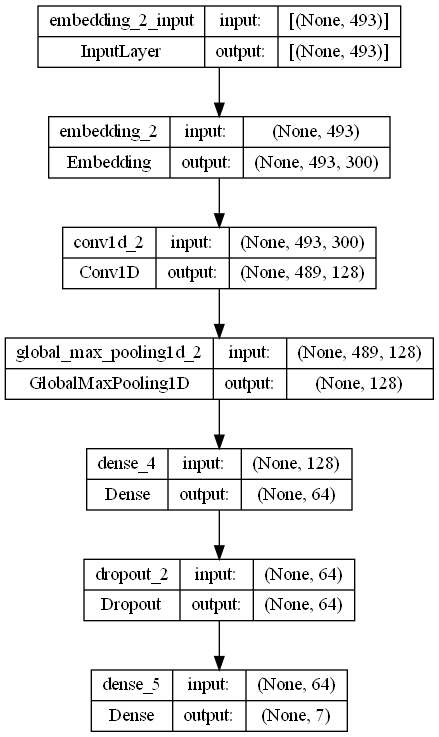

Epoch 1/50
187/187 [==============================] - 6s 32ms/step - loss: 0.3711 - accuracy: 0.5789 - val_loss: 0.8954 - val_accuracy: 0.7171
Epoch 2/50
187/187 [==============================] - 6s 33ms/step - loss: 0.2696 - accuracy: 0.7035 - val_loss: 0.7516 - val_accuracy: 0.7338
Epoch 3/50
187/187 [==============================] - 6s 34ms/step - loss: 0.2182 - accuracy: 0.7602 - val_loss: 0.6797 - val_accuracy: 0.7706
Epoch 4/50
187/187 [==============================] - 7s 35ms/step - loss: 0.1863 - accuracy: 0.7943 - val_loss: 0.6582 - val_accuracy: 0.7686
Epoch 5/50
187/187 [==============================] - 7s 35ms/step - loss: 0.1543 - accuracy: 0.8359 - val_loss: 0.6308 - val_accuracy: 0.7826
Epoch 6/50
187/187 [==============================] - 6s 35ms/step - loss: 0.1315 - accuracy: 0.8485 - val_loss: 0.6215 - val_accuracy: 0.7799
Epoch 7/50
187/187 [==============================] - 7s 35ms/step - loss: 0.1075 - accuracy: 0.8801 - val_loss: 0.6961 - val_accuracy: 0.7799

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import regularizers, constraints
from tensorflow.keras.preprocessing.sequence import pad_sequences
from gensim.models import KeyedVectors
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model
from IPython.display import display, Image
import tempfile

# Cargamos el dataset
dataset = yaml_to_dataset('/Users/34653/Desktop/new_dataset.yml')

# Aplicamos el preprocesado
preprocessed_data = [preprocess_tokenize_spanish(text) for text in dataset['data']]

# Convertimos las etiquetas en string a enteros
label_dict = {label: i for i, label in enumerate(set(dataset['labels']))}
labels = [label_dict[label] for label in dataset['labels']]


# Creamos el vocabulario
tokenizer = Tokenizer()
tokenizer.fit_on_texts(preprocessed_data)

# Convertimos el texto en secuencias
sequences = tokenizer.texts_to_sequences(preprocessed_data)

# Añadimos padding
padded_sequences = pad_sequences(sequences, padding='post')

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)
X_train = np.array(X_train)
y_train = np.array(y_train)

# Cargamos el modelo de Word2Vec
word2vec_model = KeyedVectors.load_word2vec_format('/Users/34653/Desktop/cc.es.300.vec', binary=False)

# Creamos la matriz de embeddings
vocab_size = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocab_size, word2vec_model.vector_size))
for word, i in tokenizer.word_index.items():
    if word in word2vec_model:
        embedding_matrix[i] = word2vec_model[word]


# Calculamos pesos para las clases, cuanto menor sea el número de ocurrencias mayor importancia, para combatir el desbalanceo
weights = class_weight.compute_sample_weight('balanced', labels)
class_weights = dict(enumerate(weights))

# Definimos el modelo
model = tf.keras.Sequential([
    layers.Embedding(vocab_size, word2vec_model.vector_size, weights=[embedding_matrix], input_length=len(padded_sequences[0]), trainable=False),
    layers.Conv1D(128, 5, activation='relu'),
    layers.GlobalMaxPooling1D(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(7, activation='softmax', kernel_constraint=constraints.MaxNorm(max_value=2, axis=0))
])


# Compilamos el modelo
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
earlystop = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=10)

# Mostramos el modelo
_, temp_file_path = tempfile.mkstemp(suffix='.png')
plot_model(model, to_file=temp_file_path, show_shapes=True, show_layer_names=True)
display(Image(temp_file_path))

# Entrenamos el modelo
model.fit(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[earlystop], class_weight=class_weights)

59/59 [==============================] - 1s 10ms/step
                          precision    recall  f1-score   support

              Motivacion       0.87      0.79      0.83       202
        Neurolinguistica       0.86      0.55      0.67        11
Solicitud de informacion       0.82      0.90      0.86       876
                 Pedidos       0.54      0.51      0.52        85
                  Envios       0.65      0.39      0.49        33
        Problema tecnico       0.74      0.57      0.64       215
            Duda teorica       0.82      0.84      0.83       447

                accuracy                           0.81      1869
               macro avg       0.76      0.65      0.69      1869
            weighted avg       0.80      0.81      0.80      1869



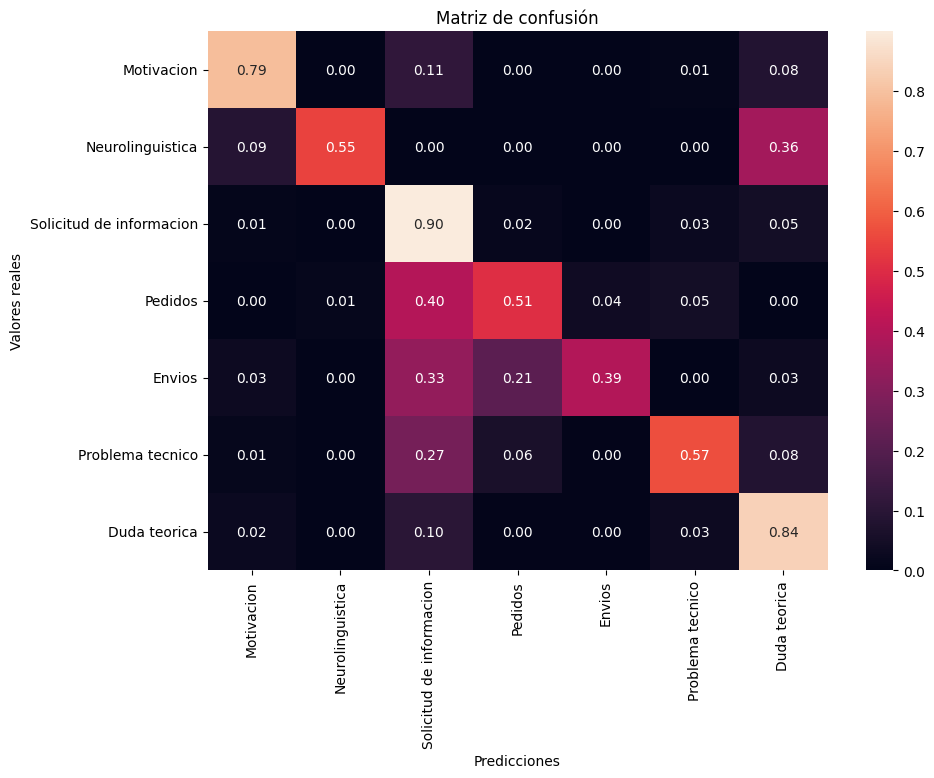

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Reverse the label_dict
reverse_label_dict = {v: k for k, v in label_dict.items()}

# Order the names of the classes according to their corresponding indices
class_names = [reverse_label_dict[i] for i in range(len(reverse_label_dict))]

# Predecimos con los datos de test
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_classes, target_names=class_names))

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Normalize the confusion matrix to get percentages
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm_norm, annot=True, fmt=".2f", xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Valores reales')
plt.xlabel('Predicciones')
plt.title('Matriz de confusión')
plt.show()

<p align="justify"> Una vez probada la red neuronal convolucional con su aplicación a la clasificación de texto. Vamos a usar una red recurrente, en este caso vamos a crear un modelo que utiliza LSTM bidireccional, es decir cada capa LSTM se aplica en ambos sentidos, de principio a fin y a la inversa.

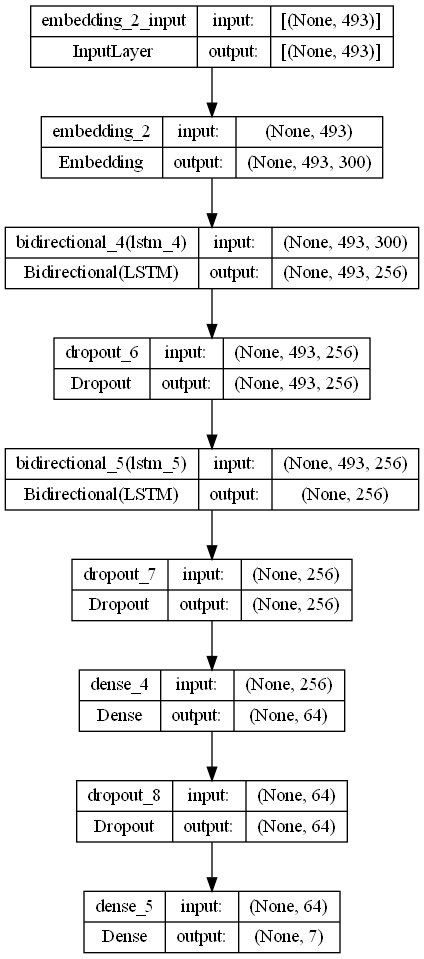

Epoch 1/50
187/187 [==============================] - 353s 2s/step - loss: 0.3544 - accuracy: 0.6155 - val_loss: 0.8598 - val_accuracy: 0.6903
Epoch 2/50
187/187 [==============================] - 347s 2s/step - loss: 0.2624 - accuracy: 0.7195 - val_loss: 0.7568 - val_accuracy: 0.7398
Epoch 3/50
187/187 [==============================] - 348s 2s/step - loss: 0.2295 - accuracy: 0.7543 - val_loss: 0.6489 - val_accuracy: 0.7786
Epoch 4/50
187/187 [==============================] - 347s 2s/step - loss: 0.2070 - accuracy: 0.7769 - val_loss: 0.6643 - val_accuracy: 0.7753
Epoch 5/50
187/187 [==============================] - 349s 2s/step - loss: 0.1895 - accuracy: 0.7906 - val_loss: 0.6035 - val_accuracy: 0.7866
Epoch 6/50
187/187 [==============================] - 346s 2s/step - loss: 0.1770 - accuracy: 0.8092 - val_loss: 0.5825 - val_accuracy: 0.8033
Epoch 7/50
187/187 [==============================] - 349s 2s/step - loss: 0.1629 - accuracy: 0.8232 - val_loss: 0.5499 - val_accuracy: 0.8114

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import regularizers, constraints
from tensorflow.keras.preprocessing.sequence import pad_sequences
from gensim.models import KeyedVectors
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from IPython.display import display, Image
import tempfile


# Cargamos el dataset
dataset = yaml_to_dataset('/Users/34653/Desktop/new_dataset.yml')

# Aplicamos el preprocesado
preprocessed_data = [preprocess_tokenize_spanish(text) for text in dataset['data']]

# Convertimos las etiquetas en string a enteros
label_dict = {label: i for i, label in enumerate(set(dataset['labels']))}
labels = [label_dict[label] for label in dataset['labels']]


# Creamos el vocabulario
tokenizer = Tokenizer()
tokenizer.fit_on_texts(preprocessed_data)

# Convertimos el texto en secuencias
sequences = tokenizer.texts_to_sequences(preprocessed_data)

# Añadimos padding
padded_sequences = pad_sequences(sequences, padding='post')
max_sequence_length = len(padded_sequences[0])

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)
X_train = np.array(X_train)
y_train = np.array(y_train)

# Cargamos el modelo de Word2Vec
word2vec_model = KeyedVectors.load_word2vec_format('/Users/34653/Desktop/cc.es.300.vec', binary=False)

# Creamos la matriz de embeddings
vocab_size = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocab_size, word2vec_model.vector_size))
for word, i in tokenizer.word_index.items():
    if word in word2vec_model:
        embedding_matrix[i] = word2vec_model[word]


# Calculamos pesos para las clases, cuanto menor sea el número de ocurrencias mayor importancia, para combatir el desbalanceo
weights = class_weight.compute_sample_weight('balanced', labels)
class_weights = dict(enumerate(weights))

model = tf.keras.Sequential([
    layers.Embedding(vocab_size, word2vec_model.vector_size, input_length=max_sequence_length, weights=[embedding_matrix], trainable=False),
    layers.Bidirectional(layers.LSTM(128, return_sequences=True)),
    layers.Dropout(0.2),
    layers.Bidirectional(layers.LSTM(128)),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(7, activation='softmax')
])

# Compilamos el modelo
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
earlystop = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5)

# Mostramos el modelo
_, temp_file_path = tempfile.mkstemp(suffix='.png')
plot_model(model, to_file=temp_file_path, show_shapes=True, show_layer_names=True)
display(Image(temp_file_path))


# Entrenamos el modelo
model.fit(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[earlystop], class_weight=class_weights)

59/59 [==============================] - 44s 740ms/step
                          precision    recall  f1-score   support

            Duda teorica       0.88      0.78      0.83       447
        Neurolinguistica       0.88      0.64      0.74        11
Solicitud de informacion       0.84      0.88      0.86       876
        Problema tecnico       0.68      0.71      0.70       215
              Motivacion       0.87      0.83      0.85       202
                  Envios       0.86      0.18      0.30        33
                 Pedidos       0.49      0.66      0.56        85

                accuracy                           0.81      1869
               macro avg       0.78      0.67      0.69      1869
            weighted avg       0.82      0.81      0.81      1869



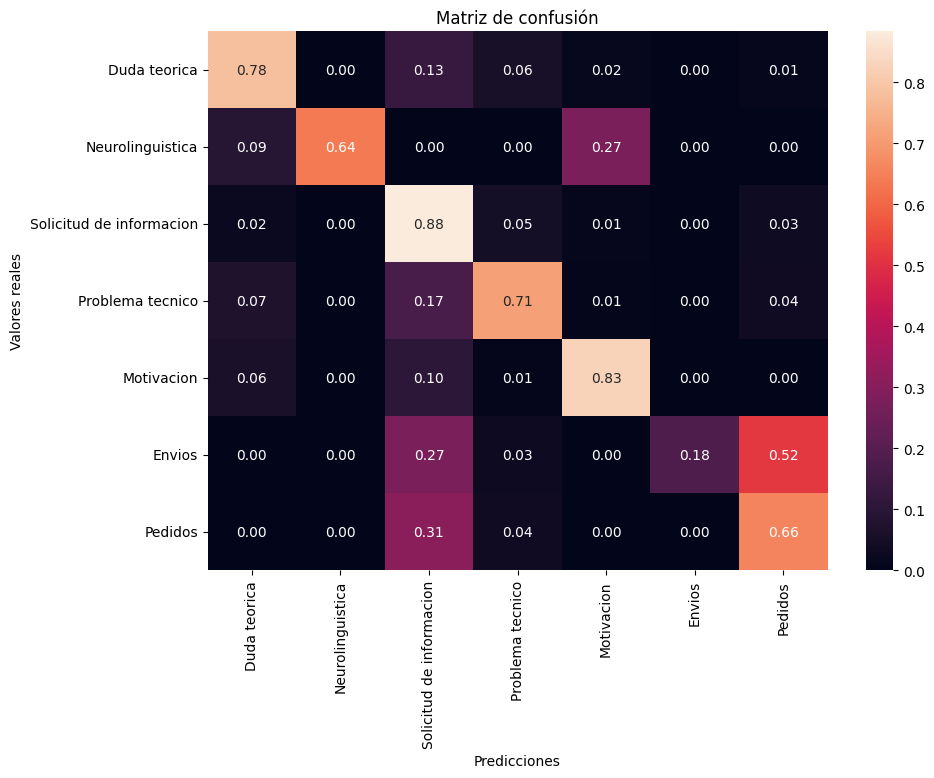

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Reverse the label_dict
reverse_label_dict = {v: k for k, v in label_dict.items()}

# Order the names of the classes according to their corresponding indices
class_names = [reverse_label_dict[i] for i in range(len(reverse_label_dict))]


# Predecimos con los datos de test
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_classes, target_names=class_names))

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Normalize the confusion matrix to get percentages
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm_norm, annot=True, fmt=".2f", xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Valores reales')
plt.xlabel('Predicciones')
plt.title('Matriz de confusión')
plt.show()

<p align="justify">Como podemos comprobar los resultados ofrecidos por las redes son bastantes prometedores con accuracies de 80-81% y con macro-avg de 0.68 y 0.71 respectivamente. Estos resultados son muy similares a los ofrecidos por el mejor de los modelos explicados en el capítulo anterior: Support Vector Machine. Es por ello que en el siguiente capítulo vamos a entrenar modelos que actualmente ofrecen los mejores resultados para problemas de clasificación de texto: Los transformers.